# Statistical Analysis and Modeling of the Chicago Food Inspections Data
This notebook loads the feature set created in the `data_prep` notebook and applies a variety of statistical methods and models to analyze the data.  See the `data_prep` notebook for information about the Chicago Food Inspections Data, the license, and the various data attributes.  

**Analysis and Models in this notebook:**

- Descriptive analysis of types of food establishments that fail inspections at the highest rates
- K Means++ on risk scores to see if data points actually cluster according to these 3 risk groupings
- Comparison of ML models for predicting a failure
- Analysis of predictive variables from Lasso logistic regression model

### Set Global Seed

In [1]:
SEED = 666

### Imports

In [2]:
from collections import Counter, OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from pylab import figure

from scipy.stats.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

### Read Chicago Food Inspections Feature Dataset from the Data Prep Notebook

In [3]:
feature_df = pd.read_csv('../data/Feature_Dataset.gz', compression='gzip')

In [4]:
feature_df.shape

(169305, 96)

### Descriptive Analysis of Failures Rates by Category
- By risk group
- By facility type
- By inspection type
- By zip

In [5]:
def get_failure_rates(feature_df, category):
    
    groups_df = (feature_df.groupby([category])[['result']].sum() / 
                 feature_df.groupby([category])[['result']].count()
                ).reset_index()
    
    return Counter(dict(zip(groups_df[category].tolist(), groups_df['result'].tolist())))

In [6]:
def plot_failure_rates(count_dict, category, n=20, x_size=8, y_size=8, color='orange'):
    
    top_words = OrderedDict(sorted(count_dict.most_common(n), key=lambda x: x[1]))
    
    
    plt.figure(figsize=(x_size, y_size))
    plt.barh(range(len(top_words)), top_words.values(), align='center', color=color)
    plt.yticks(range(len(top_words)), list(top_words.keys()))
    
    plt.title('Failure Rate by Food Establishment: {}'.format(category), size=18)
    plt.xlabel('Failure Rate', size=18)
    plt.ylabel('Groups', size=18)

    plt.show()

### Create Categorical Columns by "Un-One-Hot-Encoding" via the "idxmax" Method

In [7]:
cols = feature_df.columns
feature_df['facility_type'] = feature_df[[col for col in cols if 'facility_type' in col]].idxmax(axis=1)
feature_df['inspection_type'] = feature_df[[col for col in cols if 'inspection_type' in col]].idxmax(axis=1)
feature_df['zip'] = feature_df[[col for col in cols if 'zip' in col]].idxmax(axis=1)

### Create Dictionaries of Failure Rates

In [8]:
risk_dict = get_failure_rates(feature_df, 'risk')
facility_type_dict = get_failure_rates(feature_df, 'facility_type')
inspection_type_dict = get_failure_rates(feature_df, 'inspection_type')
zip_dict = get_failure_rates(feature_df, 'zip')

### Plot Failure Rates by Risk Group

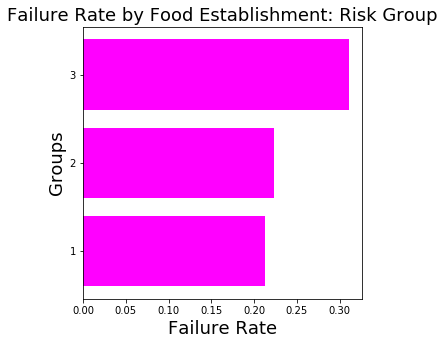

In [9]:
plot_failure_rates(risk_dict, category='Risk Group', n=30, x_size=5, y_size=5, color='magenta')

### Check if there is a Significant Difference in Failure Rates between Groups 1 and 2
Null hypothesis is that there is no difference in failure rate between the two groups.  By convention, we use a significance level of 0.05.  Here we use the Welch Test to avoid assuming constant variance, though we do assume independence of samples, which we would expect, as it seems unlikely that the same establishment was evaluated as being both a 1 and a 2.

In [10]:
t, p = ttest_ind(feature_df['result'][feature_df['risk'] == 1].values,
                 feature_df['result'][feature_df['risk'] == 2].values,
                 equal_var=False)

In [11]:
p

6.887847836227513e-05

### Plot Failure Rates by Facility Type

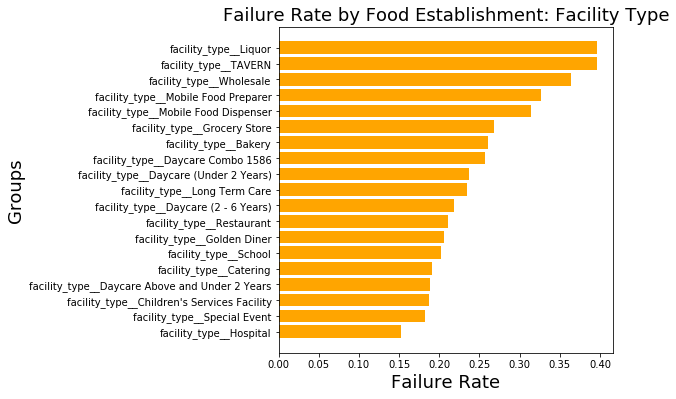

In [12]:
plot_failure_rates(facility_type_dict, category='Facility Type', n=30, x_size=6, y_size=6, color='orange')

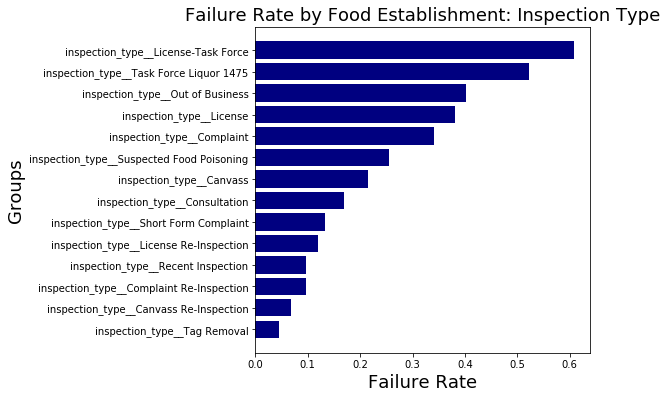

In [13]:
plot_failure_rates(inspection_type_dict, category='Inspection Type', n=30, x_size=6, y_size=6, color='navy')

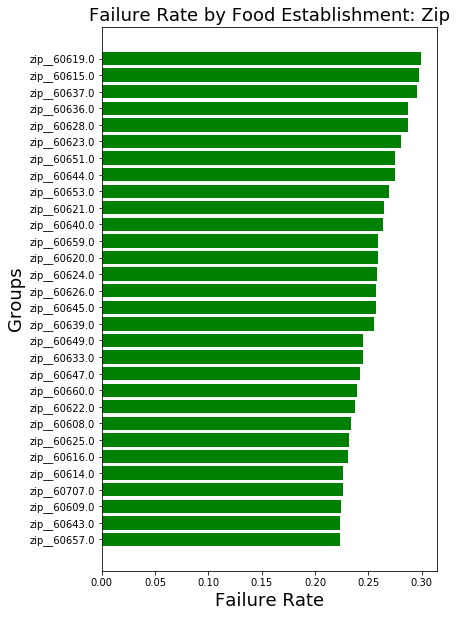

In [14]:
plot_failure_rates(zip_dict, category='Zip', n=30, x_size=6, y_size=10, color='green')

### Drop Extra Columns from Failure Rate Analysis

In [15]:
feature_df = feature_df.drop(['facility_type', 'inspection_type', 'zip'], 1)

### Split Dataset into Train and Test

In [16]:
train_df, test_df = train_test_split(feature_df,
                                     test_size=0.20,
                                     shuffle=True,
                                     random_state=SEED)

In [17]:
train_df.shape

(135444, 96)

In [18]:
test_df.shape

(33861, 96)

### Drop ID and Target Columns in Feature Matrix and Select Target Vector for Training

In [19]:
X_train = train_df.drop(['inspection_id', 'result'], 1)
X_test = test_df.drop(['inspection_id', 'result'], 1)
y_train = train_df['result']
y_test = test_df['result']

### Define Function to Analyze Variance Explained per Number of Principle Components

In [20]:
def plot_pca(X):
    """
    Plots variance explained per number of principle components.
    """
    
    pca_full = PCA(n_components=min(X.shape[0], X.shape[1]))
    pca_full.fit(X)

    plt.clf()
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Variance Explained by Principal Components')
    plt.show()

### Define Function to Plot the Value of the K Means++ Objective Function per Number of Clusters

In [21]:
def plot_kmeans(X, upper=20):
    """
    Plots value of K Means++ objective function per number of clusters.
    """
    
    distorsions = []
    for k in range(1, upper):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=SEED, n_jobs=-1)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)

    plt.plot(range(1, upper), distorsions)
    plt.title('K Means++ Elbow Curve')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Value of Objective Function')
    plt.show()

### Define Function to Plot K Means++ Clusters

In [22]:
def plot_clusters(X, num_clusters):
    """
    Plots datapoints and cluster assignments in 3D space.
    """

    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=SEED, n_jobs=-1)
    kmeans.fit(X)

    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    print('Centroids: \n')
    print(centroids)
    print()

    color_options = ['g', 'r', 'b', 'y', 'c', 'm', 'b', 'w']
    colors = color_options[0:num_clusters]

    c = Counter(labels)
    fig = figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')

    for i in range(len(X)):
        ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], s=10)

    for cluster in range(0, num_clusters):
        print('Cluster {} contains {} samples'.format(cluster, c[cluster]))
        
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],\
               marker='x', s=100, linewidths=5, zorder=100, c=colors)

    plt.title('Projected K Means++ Clusters', fontsize=20)
    plt.show()
    
    return kmeans

### See if We Can Reproduce Risk Clusters for the Establishments Identified by Three Risk Levels
Scale the data to make the distance comparisons equal across features.

In [23]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
col_subset_scaler = ColumnTransformer(remainder='passthrough', # passthrough features not listed
                                      transformers=[('mm', minmax_scaler, ['latitude', 'longitude'])])
Xt = col_subset_scaler.fit_transform(X_train.drop('risk', 1))

### Plot the Variance Explained per Number of Principle Components

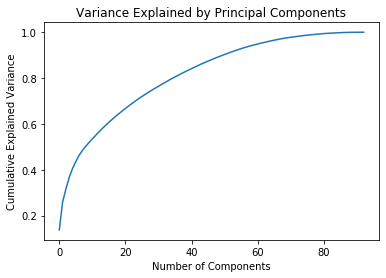

In [24]:
plot_pca(Xt)

### Plot the KMeans Objective Function for a Feature Set of Three Principle Components
It is clear that more components are needed to explain the variance in the dataset, but it's difficult to visualize more than three features in a plot.

In [25]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(Xt)

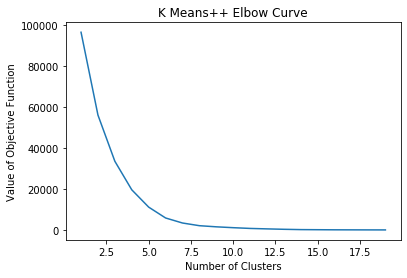

CPU times: user 1.35 s, sys: 442 ms, total: 1.79 s
Wall time: 13.1 s


In [26]:
%%time
plot_kmeans(X_PCA)

### Plot Three Clusters (for the Three Risk Groups We Might Expect) in Three Dimensions (for Easy Inspection)

Centroids: 

[[-0.65737967 -0.06938306 -0.05605089]
 [ 0.35712193  0.65788338  0.02280861]
 [ 0.3023369  -0.55404925  0.03299781]]

Cluster 0 contains 45172 samples
Cluster 1 contains 43855 samples
Cluster 2 contains 46417 samples


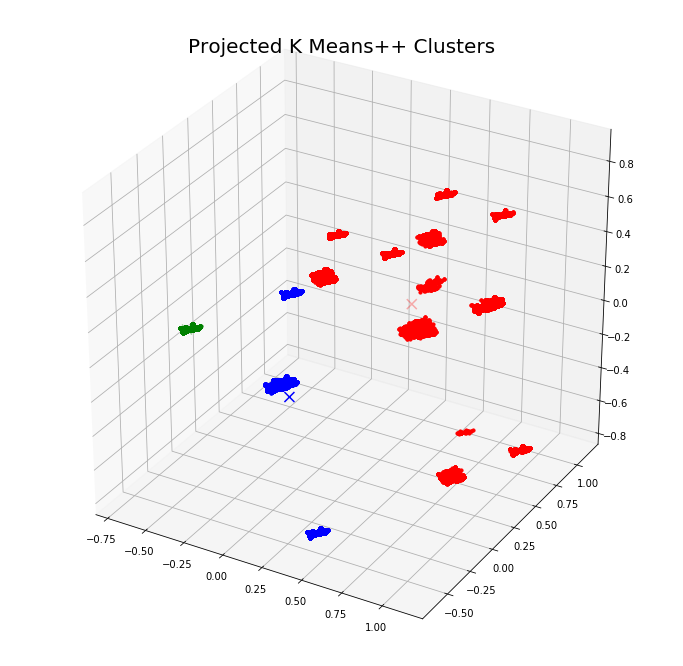

CPU times: user 9min 58s, sys: 5.24 s, total: 10min 3s
Wall time: 10min 4s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=666, tol=0.0001, verbose=0)

In [27]:
%%time
plot_clusters(X_PCA, 3)

### Summary of K Means++ Findings
1. With the small amount of variance explained by three principle components, we are unlikely to have meaningful clusters when projecting them into three dimensions.
2. It's clear by visualizing the clusters in three dimensions that there are more than three distinct clusters.

### View Prevalence of Failing an Inspection to Select a Classification Metric of Interest
Either ROC AUC or PR AUC could be useful metrics for model comparison given the prevalence of the target variable (failing an inspection).  I will preference PR AUC for model comparison, as my main interest as a user of such a model would be to balance
- **Recall:** the number of food establishments that were correctly predicted by the model to fail over the total number of food establishmets that fail.
- **Precision:** the number of food establishments that were correctly predicted by the model to fail over the number of food establishments predicted by the model to fail.

In [28]:
np.mean(y_train)

0.2219884232597974

### Define K Fold Cross-Validation Grid with Scaling to Fit Classifiers and Identify Best Hyperparameters
This function is used to select hyperparameters for all models considered and appropriately scales continuous features in-fold and out-of-fold for each of K folds.  For XGBoost, I use the random search option with 5 folds instead of 3 as the parameter space is large and I want to avoid overfitting.

In [29]:
def fit_grid(clf, param_grid, features_to_scale=['risk', 'latitude', 'longitude'],
             n_splits=3, r_search_iters=0, scoring='average_precision'):
    """
    Uses an sklearn pipeline to scale selected columns at each iteration of K Fold CV
    and fits models using the parameters in the grid passed to identify the model
    with the best mean test score based on the scoring metric supplied which
    defaults to 'average_precision'.  Uses random grid search if desired.
    """
    
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    col_subset_scaler = ColumnTransformer(remainder='passthrough', # passthrough features not listed
                                          transformers=[('mm', minmax_scaler, features_to_scale)])
    
    pipeline = Pipeline([('scaler', col_subset_scaler),
                         ('clf', clf)])
    
    cv = StratifiedKFold(n_splits=n_splits,
                         shuffle=True,
                         random_state=SEED)
    
    if r_search_iters:
        gs = RandomizedSearchCV(estimator=pipeline,
                                param_distributions=param_grid,
                                scoring=scoring,
                                cv=cv,
                                n_iter=r_search_iters,
                                refit=True,
                                n_jobs=-1,
                                random_state=SEED,
                                verbose=2)
    else:
        gs = GridSearchCV(estimator=pipeline,
                          cv=cv,
                          param_grid=param_grid,
                          scoring=scoring,
                          n_jobs=-1,
                          refit=True,
                          verbose=2)
    
    gs.fit(X_train, y_train)
    
    scores = gs.cv_results_['mean_test_score']
    best_score = round(gs.best_score_, 5)
    best_params = gs.best_params_
    best_clf = gs.best_estimator_
    
    print("Best score: {}".format(best_score))
    print("Best parameters: {}".format(best_params))
    
    return best_clf

### Define Lasso Logistic Regression Model

In [30]:
clf = LogisticRegression(penalty='l1',
                         solver='liblinear',
                         fit_intercept=True,
                         max_iter=1000)

### Define Lasso Hyperparameter Space

In [31]:
param_grid = {'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

### Fit Lasso Model with Grid Search

In [32]:
%%time
lasso_clf = fit_grid(clf, param_grid, features_to_scale=['risk', 'latitude', 'longitude'], n_splits=3)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   27.9s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   40.9s finished


Best score: 0.37507
Best parameters: {'clf__C': 1}
CPU times: user 4.47 s, sys: 720 ms, total: 5.19 s
Wall time: 44.7 s


### Define K Nearest Neighbors Model

In [33]:
clf = KNeighborsClassifier()

### Define KNN Hyperparameter Space

In [34]:
param_grid = {'clf__n_neighbors': [7, 15, 25]}

### Fit KNN Model with Grid Search

In [35]:
%%time
knn_clf = fit_grid(clf, param_grid, features_to_scale=['risk', 'latitude', 'longitude'], n_splits=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 14.7min remaining: 18.4min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 20.7min finished


Best score: 0.34788
Best parameters: {'clf__n_neighbors': 25}
CPU times: user 38.3 s, sys: 370 ms, total: 38.6 s
Wall time: 21min 20s


### Define XGBoost Model

In [36]:
clf = xgb.XGBClassifier(objective='binary:logistic',
                        tree_method='hist',
                        predictor='cpu_predictor')

### Define XGBoost Hyperparameter Space

In [37]:
param_grid = {'clf__n_estimators': [100, 200, 400, 600],
              'clf__learning_rate': [0.05, 0.1, 0.2],
              'clf__max_depth': [3, 4, 5, 6, 7],
              'clf__subsample': [0.3, 0.5, 0.7],
              'clf__colsample_bytree': [0.3, 0.5, 0.7],
              'clf__min_child_weight': [3, 5, 7]}

### Fit XGBoost Model with Random Grid Search
This is potentially overkill for this problem, but I use 5 folds and 50 iterations of random search to achieve a stable estimate of the best hyperparameters.  Fitting this model provides a good sense for the upper limit of predictive accuracy possible on this dataset, though there may be deep learning architectures that could push performance further.  My main interest for this analysis is an understanding of features associated with failing an inspection, and I end up going with the Lasso logistic regression model for this reason, as described further down in the notebook.

In [38]:
%%time
xgb_clf = fit_grid(clf, param_grid, features_to_scale=['risk', 'latitude', 'longitude'],
                   n_splits=5, r_search_iters=50)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.6min finished


Best score: 0.3928
Best parameters: {'clf__subsample': 0.7, 'clf__n_estimators': 400, 'clf__min_child_weight': 3, 'clf__max_depth': 6, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.5}
CPU times: user 29 s, sys: 956 ms, total: 29.9 s
Wall time: 7min 1s


### Evaluate Classifiers on Test Set

In [56]:
def plot_hist(labels, scores, bins=30):
    """
    Plot two histograms: one of
    the actual binary labels
    and one of the model scores
    """
    
    plt.clf()
    plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    sns.distplot(labels, kde=False, color='orange')
    plt.xlabel('Actual Label', fontsize=12)
    plt.xticks([0, 1])
    plt.subplot(222)
    sns.distplot(scores, bins=bins, kde=False, color='orange')
    plt.xlabel('Scores', fontsize=12)
    plt.xticks([0, 0.25, 0.5, 0.75, 1])
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(223)
    sns.distplot(scores[labels == 0], bins=bins, kde=False, color='orange')
    plt.xlabel('Actual Label = 0', fontsize=12)
    plt.subplot(224)
    sns.distplot(scores[labels == 1], bins=bins, kde=False, color='orange')
    plt.xlabel('Actual Label = 1', fontsize=12)
    plt.suptitle('Histograms of Model Scores by Actual Label', fontsize=16)
    plt.show()

In [57]:
def plot_roc(labels, scores):
    """
    Plots the true positive rate vs. the false positive rate
    """

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.clf()
    plt.plot(fpr, tpr, color='darkgreen', lw=2,
             label='AUC = %0.3f' % (roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.suptitle('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")

    plt.show()

In [58]:
def plot_pr_by_threshold(labels, scores):
    """
    Plots model precision and recall
    by threshold, using matplotlib and seaborn
    allowing a user to visualize model performance
    at various thresholds
    """
    
    auc = round(average_precision_score(y_true=labels, y_score=scores), 3)
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    thresholds = np.append(thresholds, 1)

    plt.clf()
    plt.plot(thresholds, precision, color=sns.color_palette()[0])
    plt.plot(thresholds, recall, color=sns.color_palette()[1])

    leg = plt.legend(('Precision', 'Recall'), frameon=True)
    leg.get_frame().set_edgecolor('k')

    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.suptitle('Precision and Recall by Model Threshold - AUC: {}'.format(auc), fontsize=16)

    plt.show()

### View Lasso Model Performance

In [42]:
y_prob = lasso_clf.predict_proba(X_test)[:, 1]

<Figure size 432x288 with 0 Axes>

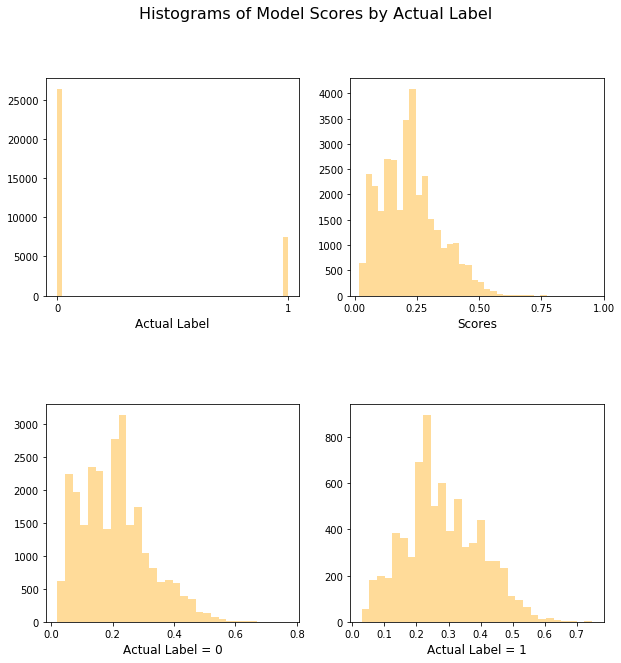

In [43]:
plot_hist(y_test, y_prob)

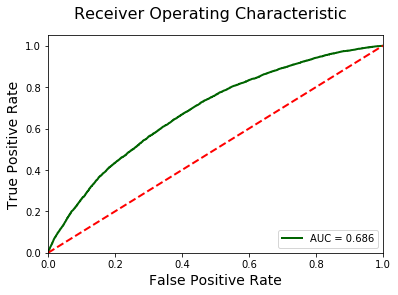

In [44]:
plot_roc(y_test, y_prob)

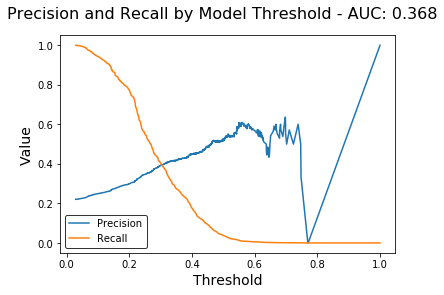

In [45]:
plot_pr_by_threshold(y_test, y_prob)

### View KNN Model Performance

In [46]:
y_prob = knn_clf.predict_proba(X_test)[:, 1]

<Figure size 432x288 with 0 Axes>

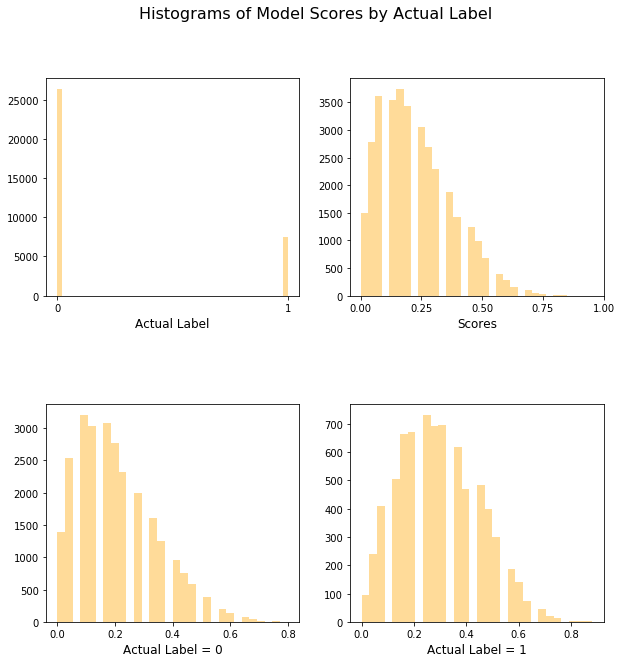

In [47]:
plot_hist(y_test, y_prob)

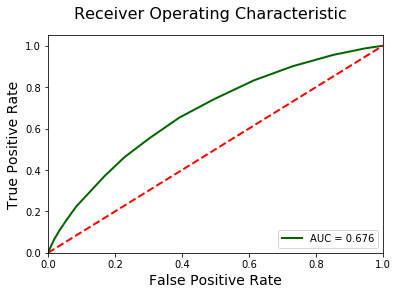

In [48]:
plot_roc(y_test, y_prob)

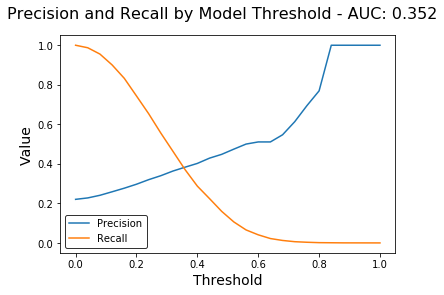

In [49]:
plot_pr_by_threshold(y_test, y_prob)

### View XGBoost Model Performance

In [50]:
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

<Figure size 432x288 with 0 Axes>

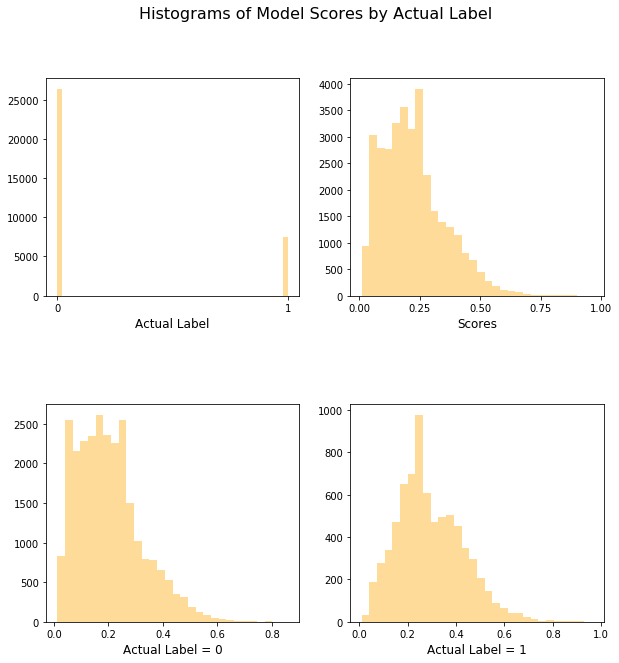

In [51]:
plot_hist(y_test, y_prob)

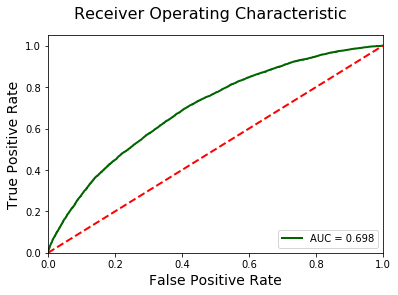

In [52]:
plot_roc(y_test, y_prob)

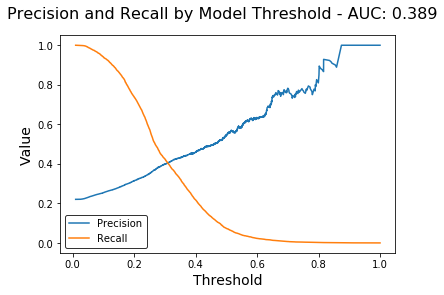

In [53]:
plot_pr_by_threshold(y_test, y_prob)

### Model Summary
Fitting all three models is informative because it demonstrates how effective we might reasonably expect an ML model to be at classifying food establishments as expected to fail or pass an inspection.  That said, we see that no model achieves particularly high AUC, and that we are forced to have either low recall or low precision when choosing a threshold for model scores.  Because the Lasso model is about as performant as the XGBoost model with fewer parameters to tune, there is good reason to prefer the Lasso model for its interpretability.

### Interpreting Features
For the purpose of this analysis, we are particularly concerned with understanding the factors associated with passing or failing an inspection, and the Lasso logistic regression model provides a nice way to understand these factors by examining the odds of passing or failing an inspection per unit change in each individual predictor, controlling for all other features in the model.  Because all predictors are either binary or on the scale of 0 to 1, we can interpret the bars for each feature as:
- The odds of failure if the feature is present vs absent for binary features
- The odds of failure if the feature achieves its max vs min value for continuous features with in between values corresponding to less severe changes in the odds of the response.

In [54]:
def plot_coef_effect_size(clf, features, zero_threshold=0.01, x_size=12, y_size=12):
    """
    Plots the change in the odds of the response per unit change 
    in the predictor for each feature given a logistic
    regression model and array of features.  Uses the zero 
    threshold to only plot features with coefficient value
    greater than the threshold.
    """

    features_and_intercept = np.concatenate((features, ['intercept']), 0)
    coefficients = np.concatenate((clf.coef_[0], clf.intercept_), 0)

    coefficients[np.abs(coefficients) < zero_threshold] = 0
    coefficients = np.exp(coefficients)

    idx1 = coefficients.argsort()
    all_effects = coefficients[idx1]

    idx2 = np.nonzero(all_effects-1.0)
    effects = all_effects[idx2]
    labels = features_and_intercept[idx1][idx2]
    
    plt.clf()
    plt.figure(figsize=(x_size, y_size))

    plt.title('Exponentiated Logistic Regression Coefficients')
    plt.barh(range(len(effects)), effects, color='navy', align='center')
    plt.axvline(x=1, color='red', linestyle='--')
    plt.yticks(range(len(effects)), labels)
    plt.xlabel('Change in Odds of Response per Unit Change in Predictor')
    plt.ylabel('Feature')
    
    plt.legend(['No Change', 'Change in Odds of Response per Unit Change in Predictor'])

    plt.show()

### Plot the Effect Sizes for Features for which the Raw Coefficient is < -0.5 or > 0.5
The effect sizes are the exponentiated coefficients which detail the change in the odds of the response per unit change in the predictor.

<Figure size 432x288 with 0 Axes>

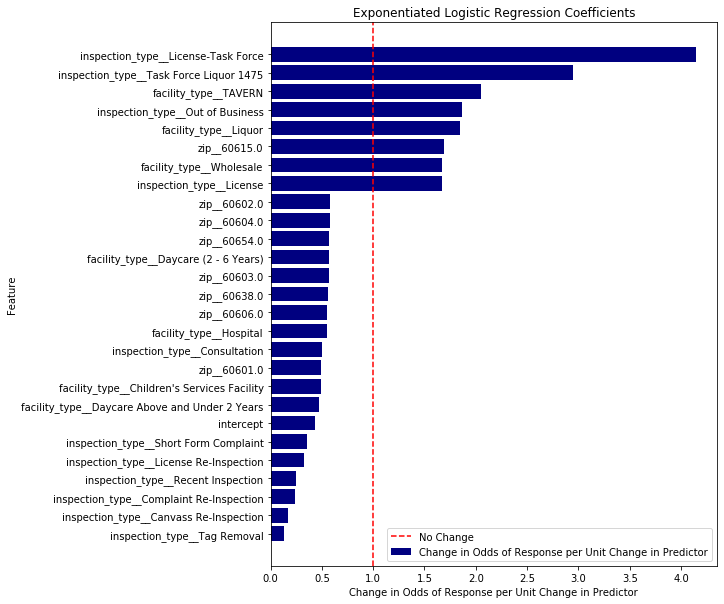

In [55]:
plot_coef_effect_size(lasso_clf['clf'], X_train.columns, zero_threshold=0.5, x_size=8, y_size=10)